# Titanic Top 4% with ensemble modeling

[타이타닉 3번 커널](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

# Contents

1. Introduction
2. Load and Check Data  
$\;$ 2.1 Load Data  
$\;$ 2.2 Outlier Detection  
$\;$ 2.3 Joining Train and Test Set  
$\;$ 2.4 Check for Null and Missing Values  
3. Feature Analysis  
$\;$ 3.1 Numericcal Values  
$\;$ 3.2 Categorical Values
4. Filling Missing Values  
$\;$ 4.1 Age
5. Feature Engineering  
$\;$ 5.1 Name / Title  
$\;$ 5.2 Family Size  
$\;$ 5.3 Cabin  
$\;$ 5.4 Ticket
6. Modeling  
$\;$ 6.1 Simple Modeling  
$\;$$\quad$ 6.1.1 Cross Validate Models  
$\;$$\quad$ 6.1.2 Hyperparameter Tunning for Best Models  
$\;$$\quad$ 6.1.3 Plot Learning Curves  
$\;$$\quad$ 6.1.4 Feature Importance of the Tree Based Classifiers  
$\;$ 6.2 Ensembling Modeling  
$\;$$\quad$ 6.2.1 Combining Models  
$\;$ 6.3 Prediction  
$\;$$\quad$ 6.3.1 Predict and Submit Results

<br>

# 1. Introduction

This is my first kernel at Kaggle. I choosed the Titanic competition which is a good way to introduce feature engineering and ensembling modeling. Firstly, I will display some feature analyses then I'll focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.

이건 나의 캐글 첫 번째 커널이다. 나는 특성 공학(Feature Engineering)과 앙상블 모델링을 소개하기 위한 좋은 방법인 타이타닉 대회를 선택했다. 먼저 특성 분석 몇 개 표시한 후 특성 공학에 초점을 맞추겠다. 마지막 부분은 투표 절차를 이용하여 타이타닉의 생존을 모델링하고 예측하는 것이다.

This script follows three main parts:  
- Feature Analysis
- Feature Engineering
- Modeling

이 스크립트는 3개의 주요 파트로 이루어져 있다.:  
- 특성 분석
- 특성 공학
- 모델링

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and Check Data

## 2.1 Load Data

In [2]:
## Load data
# Load train and Test Set
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
IDtest = test["PassengerId"]

## 2.2 Outlier Detection

In [3]:
# Outlier Detection
def detect_outliers(df, n, features) :
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers
    according to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # Outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step)
                              |
                              (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

# detect outliers from Age, SibSp, Parch anad Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age","SibSp","Parch","Fare"])

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Since outliers can have a dramatic effect on the prediction (espacially for regression problems), I choosed to manage them.

이상치가 예측에 극적인 영향을 미칠 수 있기 때문에(특히 회귀 문제에 대해서), 나는 그것들을 관리하기로 했다.

I used the Tukey method (Tukey JW., 1977) to detect outliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

Tukey 방법(Tukey JW, 1977년)을 사용하여 분포 값의 1사분위수와 3사분위수 사이에 구성된 사분위범위(IQR)를 정의하는 이상치를 검출했다. 이상치란 (IQR +- 이상치 단계)를 벗어난 특성 값을 가진 행이다.

I decided to detect outliers fromm the numerical values features (Age, SibSp, Parch and Fare). Then, I considered outliers as rows that have at least two outlied numerical values.

나는 수치형 특성(Age, SibSp, Parch, Fare)에서 이상치를 검출하기로 결정했다. 그런 다음, 최소 2개 이상의 이상치의 수치 값을 갖는 행을 이상치로 간주했다.

In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare.

우리는 10개의 이상치를 탐지했다. 28, 89, 342번 승객은 높은 티켓 가격(Fare)을 가지고 있다.

In [5]:
train.loc[(train["PassengerId"]==28)|(train["PassengerId"]==89)|(train["PassengerId"]==342)][["PassengerId","Fare"]]

,PassengerId,Fare
27,28,263.0
88,89,263.0
341,342,263.0


The 7 others have very high values of SibSp.

나머지 7명의 승객은 높은 SibSp 값을 가지고 있다.

In [6]:
train.loc[Outliers_to_drop].loc[(train["PassengerId"]!=28)&(train["PassengerId"]!=89)&(train["PassengerId"]!=342)][["PassengerId","SibSp"]]

,PassengerId,SibSp
159,160,8
180,181,8
201,202,8
324,325,8
792,793,8
846,847,8
863,864,8


In [7]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 Joining Train and Test Set

In [8]:
# Join train and test datasets in order to obtain the same number of features
# during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


I join train and test datasets to obtain the same number of features during categorical conversion (See feature engineering).

나는 범주형으로 전환할 때 똑같은 숫자의 특성을 얻기 위해 훈련세트와 테스트 세트를 결합했다. (특성 공학 부분 확인)

In [9]:
print("length of train set : ", len(train))
print("length of test set : ", len(test))
print("length of train and test set : ", len(train) + len(test))
print("length of joined dataset : ", len(dataset))

length of train set :  881
length of test set :  418
length of train and test set :  1299
length of joined dataset :  1299


## 2.4 Check for null and Missing Values

In [10]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Age and Cabin features have an important part of missing values.

Age와 Cabin 특성은 결측값에서 중요한 부분이다.

**Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set).**

Survived 특성의 결측값은 테스트 데이터셋을 결합한 것과 일치한다. (Survived 열은 테스트 세트에 존재하지 않고, 훈련 세트와 테스트 세트를 연결할 때 전부 NaN 값으로 대체되었다.)

In [11]:
# Infos
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [12]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [15]:
# Summarize data
# Summarize and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature Analysis

## 3.1 Numerical Values

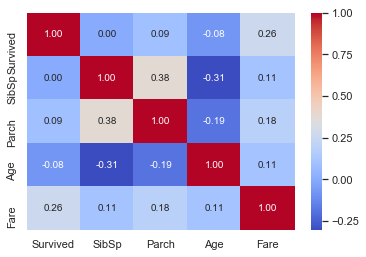

In [16]:
# Correlation matrix between numerical values (SibSp, Parch, Age and Fare values) and Survived
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),
                annot=True,
                fmt=".2f",
                cmap="coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

Fare 특성만이 생존(Survived) 특성과 주목할만한 상관관계를 가지는 것처럼 보인다.

It doesn't mean that the other features are not useful. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.

이것은 다른 특성들이 유용하지 않다는 것을 의미하진 않는다. 이 특성들의 부분 집단은 생존(Survival)과 관련될 수 있다. 이를 결정하기 위해 우리는 이 특성들의 자세한 부분을 탐색할 필요가 있다.

### 3.1.1 SibSp

In [17]:
train.Survived.value_counts()

0    541
1    340
Name: Survived, dtype: int64

In [18]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [19]:
train.SibSp.dtypes

dtype('int64')

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


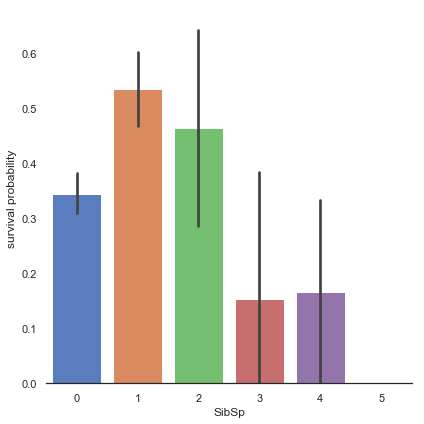

In [20]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar",
                   size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

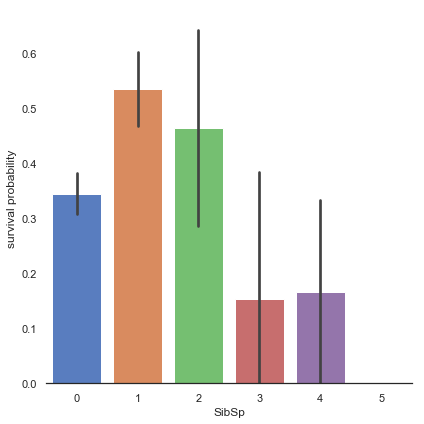

In [21]:
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive.

많은 형제자매(siblings)와 배우자(spoused)를 가진 승객은 적은 생존 기회를 갖는 것으로 보인다.

Single passengers (0 SibSp) or with two other persons (SipSp 1 or 2) have more chance to survive.

혼자 탑승한 승객(SibSp=0) 또는 2명 이내의 직계가족이 있는 승객(SibSp=1or2)은 더 많은 생존 기회를 갖는다.

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering).

이 관찰 결과는 아주 흥미롭다. 우리는 이 범주들을 묘사하는 새로운 특성을 고려할 수 있다. (특성 공학 부분에서 확인)

### 3.1.2 Parch

In [22]:
train.Parch.value_counts()

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [23]:
train.Parch.dtypes

dtype('int64')

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


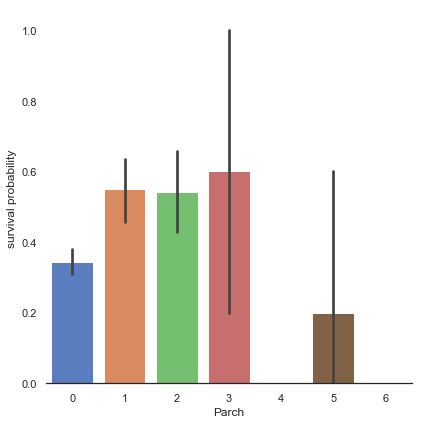

In [24]:
# Explore Parch feature vs Survived
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

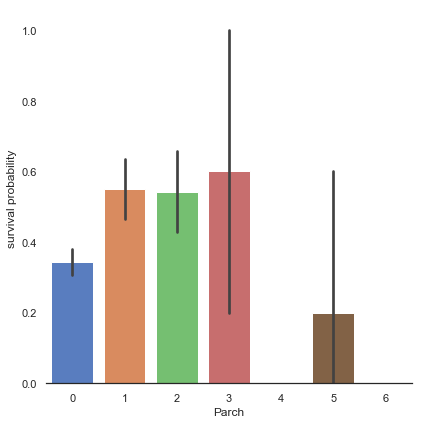

In [25]:
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6).

작은 가족들이 혼자(Parch=0), 중간(Parch=3,4) 그리고 큰 가족들(Parch=5,6)보다 더 많은 생존 기회를 갖는다.

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children.

3명의 부모 및 자녀들이 있는 승객들의 생존 확률의 표준편차가 중요하다는 것에 주의하라.

### 3.1.3 Age

In [26]:
train.Age.dtypes

dtype('float64')

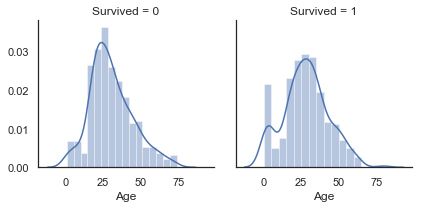

In [27]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

나이의 분포는 꼬리 분포처럼 보이며, 아마 정규 분포(gaussian distribution)일 것이다.

We notice that age distribution are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also wee that passengers between 60-80 have less survived.

우리는 연령 분포가 생존자, 생존하지 못한 사람 각각의 부분 모집단에서 서로 다르다는 것을 안다. 실제로, 살아남은 승객들의 분포에서 높은 지점이 젋은 승객들 부분과 일치한다. 우리는 또한 60-80세의 승객들의 생존 확률이 낮은 것을 알 수 있다.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

그래서 연령(Age)이 생존여부(Survived)와 관련이 없다고 하더라도, 우리는 새존할 수 있는 가능성이 더 많거나 더 적은 승객들의 연령 범주가 있다는 것을 알 수 있다.

It seems that very young passengers have more chance to survive.

젊은 승객들이 더 많은 생존 기회를 가진 것처럼 보인다.

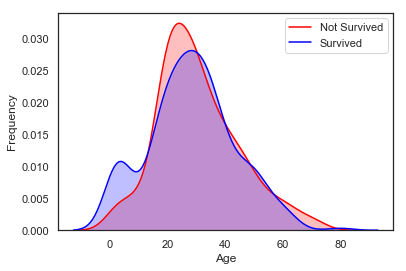

In [28]:
# Explore Age distribution
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
                color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
                color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

When we superimpose the two densities, we clearly see a peak corresponding (between 0 and 5) to babies and very young childrens.

두 밀도를 겹쳐 놓으면, 우리는 아기들과 어린 아이들에 해당하는 봉우리가 일치하는 것을 분명히 볼 수 있다.

### 3.1.4 Fare

In [29]:
train.Fare.dtypes

dtype('float64')

In [30]:
dataset['Fare'].isnull().sum()

1

In [31]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

In [32]:
dataset['Fare'].isnull().sum()

0

Since we have one missing value, I decided to fill it with the median value which will not have an important effect on the prediction.

우리가 한 개의 결측값을 갖고 있기 때문에, 나는 예측에 중요한 영향을 주지 않도록 중앙값으로 결측값을 대채하기로 결정했다.

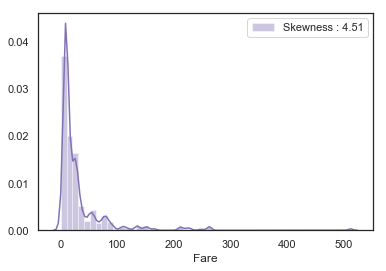

In [33]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweight very high values in the model, even if it is scaled.

우리가 볼 수 있듯이, 요금(Fare)의 분포는 매우 편향되어(skewed) 있다. 이것은 모델에서 스케일링을 하더라도 매우 높은 값이 초과될 수 있다.

In [34]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i : np.log(i) if i > 0 else 0)

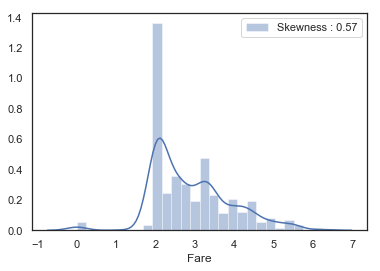

In [35]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Skewness is clearly reduced after the log transformation.

왜도(Skewness)는 로그 변환 이후 명백히 감소했다.

## 3.2 Categorical values

### 3.2.1 Sex

In [36]:
train.Sex.value_counts()

male      572
female    309
Name: Sex, dtype: int64

In [37]:
train[["Sex", "Survived"]].groupby("Sex").count()

,Survived
Sex,
female,309
male,572


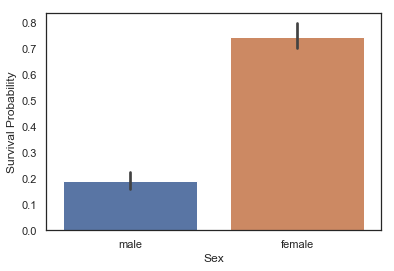

In [38]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [39]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive than Female.

남성(Male)이 여성(Female)보다 생존 기회가 더 적다는 것은 명백해 보인다.

So Sex, might play an important role in the predicion of the survival.

그래서 성별(Sex)은 생존을 예측하는 데 중요한 역할을 할 것이다.

For those who have seen the Titanic movie (1997), I am sure, we all remember this sentence during the evacuation : "Women and children first."

1997년 영화 타이타닉을 본 사람은 대피하는 동안 등장한 이 문장을 기억할 것이다.  
  
  
> "여성과 아이들이 먼저입니다."

### 3.2.2 Pclass

In [40]:
train.Pclass.value_counts()

3    484
1    213
2    184
Name: Pclass, dtype: int64

In [41]:
train[["Pclass", "Survived"]].groupby("Pclass").count()

,Survived
Pclass,
1,213
2,184
3,484


C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


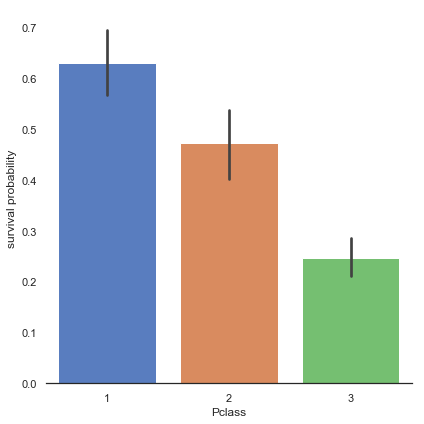

In [42]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

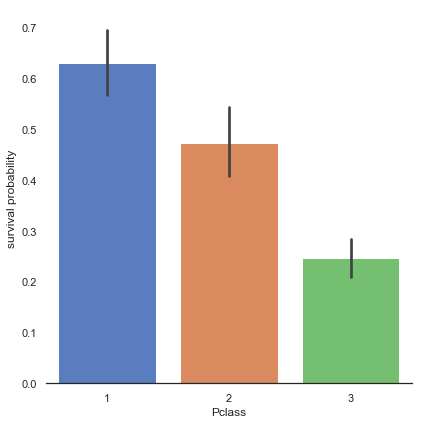

In [43]:
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


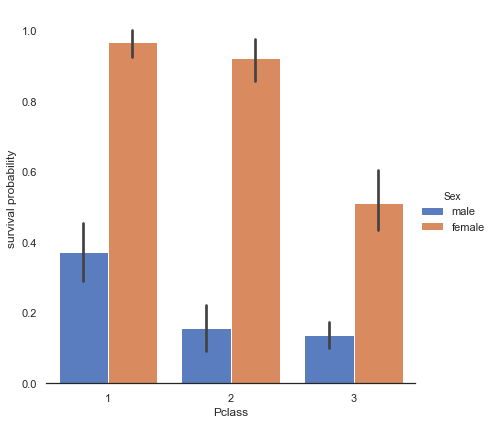

In [44]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

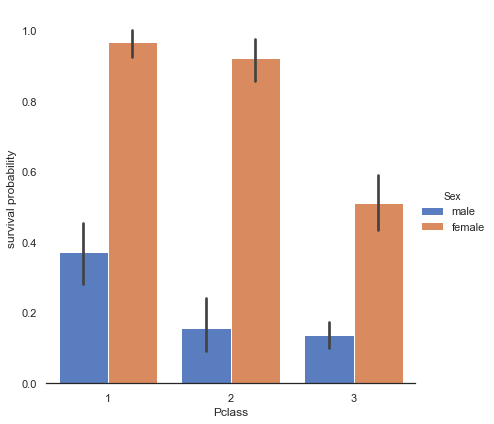

In [45]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar",
                height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

승객의 생존은 3개의 등급별로 같지 않다. 1등급 승객들은 2등급, 3등급 승객들보다 더 많은 생존 기회를 얻었다.

This trend is conserved when we look at both male and female passengers.

이러한 경향은 우리가 남성과 여성 승객을 동시에 관찰할 떄 유지된다.

### 3.2.3 Embarked

In [46]:
train.Embarked.value_counts()

S    634
C    168
Q     77
Name: Embarked, dtype: int64

In [47]:
train[["Embarked", "Survived"]].groupby("Embarked").count()

,Survived
Embarked,
C,168
Q,77
S,634


In [48]:
dataset["Embarked"].isnull().sum()

2

In [49]:
# Fill Embarked nan values of dataset set with 'S' most frequent values
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [50]:
dataset["Embarked"].isnull().sum()

0

Since we have two missing values, I decided to fill them with the most frequent value of "Embarked" (S).

2개의 결측값이 있기 때문에 나는 그것들을 가장 빈도가 높은 값인 "S"로 채웠다.

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


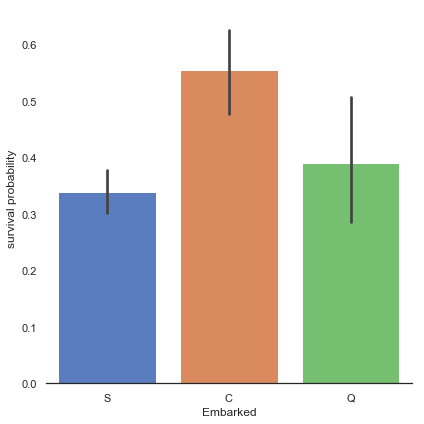

In [51]:
# Explore Embarked vs Survived
g = sns.factorplot(x="Embarked", y="Survived", data=train, kind="bar",
                   size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

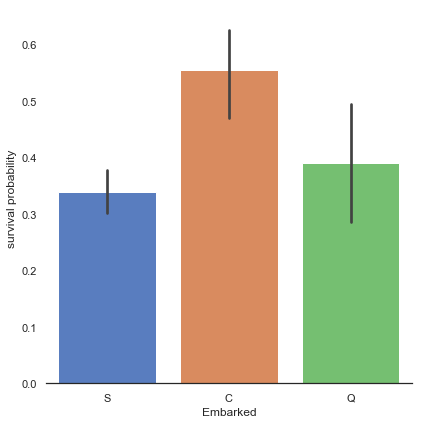

In [52]:
g = sns.catplot(x="Embarked", y="Survived", data=train, kind="bar",
                height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passenger coming from Cherbourg (C) have more chance to survive.

Cherbourg(C)에서 출발한 승객들이 더 많은 생존 기회를 갖는 것으로 보인다.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown(Q), Southampton(S0.

내 가설은 1등급 승객들의 비율은 Queenstown(Q)이나 Southampton(S) 보다 Cherbourg에서 온 비율이 더 높을 것이라는 것이다.

Let's see the Pclass distribution vs Embarked

Pclass의 분포와 Embarked를 비교해보자.

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


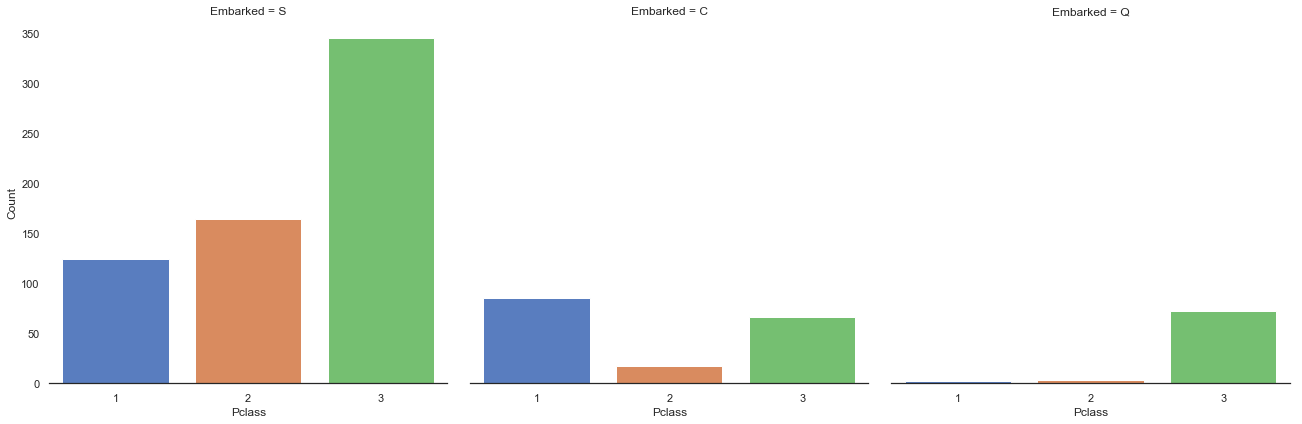

In [53]:
# Explore Pclass vs Embarked
g = sns.factorplot("Pclass", col="Embarked", data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

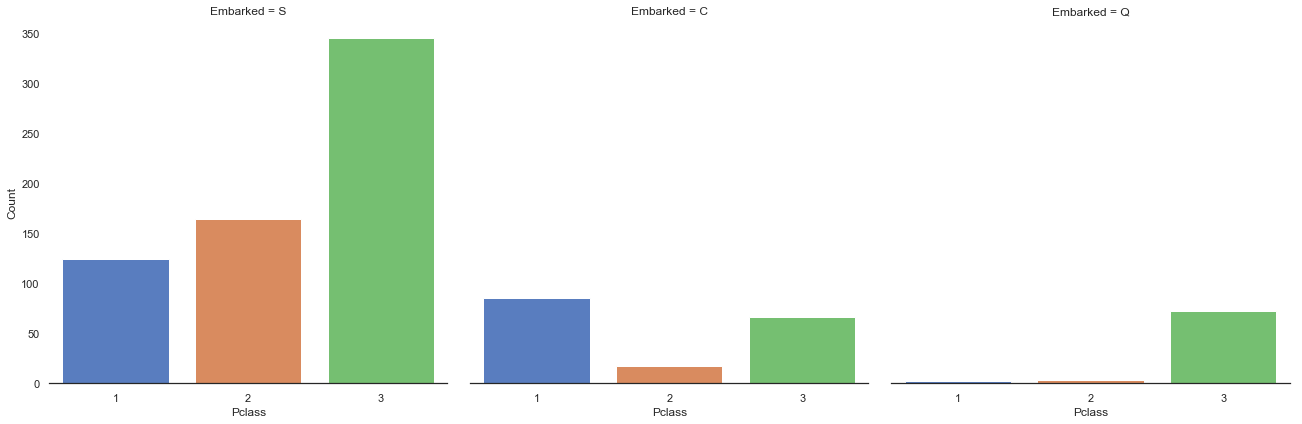

In [54]:
g = sns.catplot("Pclass", col="Embarked", data=train, height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton(S) and Queenstown(Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

실제로, 3등급 승객들은 Southampton와 Queenstown에서 온 빈도가 가장 높고, 반면에 Cherbourg 승객들은 대부분 생존 확률이 가장 높은 1등급 고객들이다.

At this point, I can't explain why first class has a higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

이 점에서는 나는 왜 1등급 승객들이 높은 생존율을 보이는 지 설명할 수 없다. 내 가설은 1등급 승객들은 그들의 영향력 때문에 대피하는 동안의 우선순위가 매겨졌다는 것이다.

# 4. Filling missing Values

## 4.1 Age

As we see, Age column contains 256 missing values in the whole dataset.

우리가 본 것처럼 연령(Age) 열은 전체 데이터셋 중에 256개의 결측값을 가지고 있다.

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

생존할 수 있는 기회가 더 많은 부분모집단(예: 어린이)이 있기 때문에 연령 특성을 유지하고 결측값으로 남기는 것이 바람직하다.

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


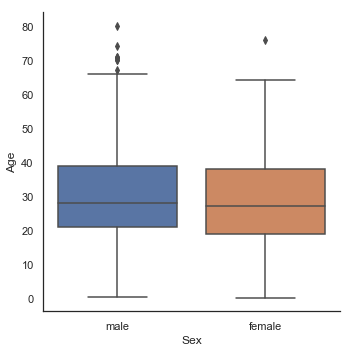

In [55]:
# Explore Age vs Sex, Parch, Pclass and SibSp
# Age VS Sex
g = sns.factorplot(y="Age", x="Sex", data=dataset, kind="box")

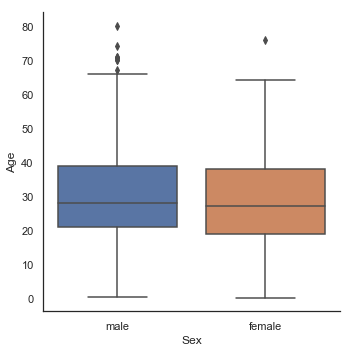

In [56]:
g = sns.catplot(y="Age", x="Sex", data=dataset, kind="box")

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


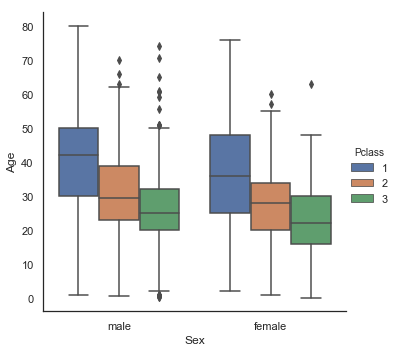

In [57]:
# Age VS Sex VS Pclass
g = sns.factorplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")

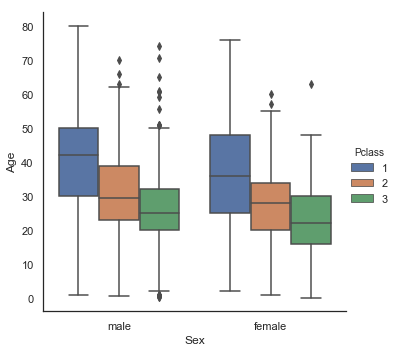

In [58]:
g = sns.catplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


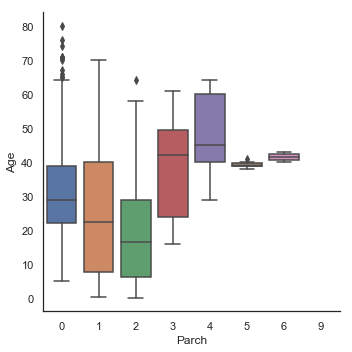

In [59]:
# Age VS Parch
g = sns.factorplot(y='Age', x="Parch", data=dataset, kind="box")

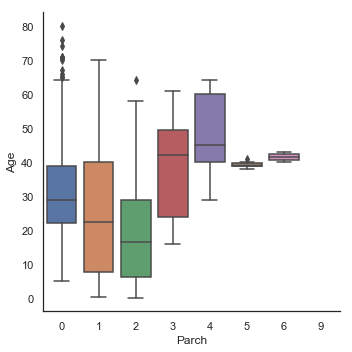

In [60]:
g = sns.catplot(y="Age", x="Parch", data=dataset, kind="box")

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


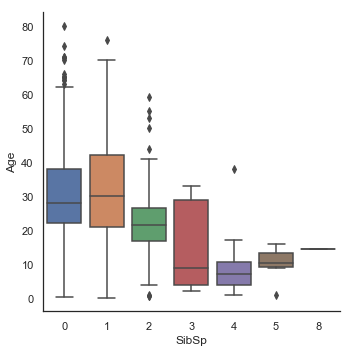

In [61]:
# Age VS SibSp
g = sns.factorplot(y="Age", x="SibSp", data=dataset, kind="box")

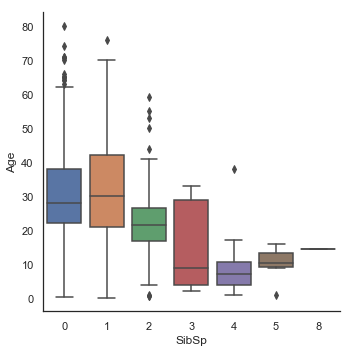

In [62]:
g = sns.catplot(y="Age", x="SibSp", data=dataset, kind="box")

Age distribution seems to be the same in Male and Femal subpopulations, so Sex is not informative to predict Age.

연령 분포는 남성과 여성 부분모집단에서 동일한 것 같아 보이므로, 성별은 나이를 예측하는 데 도움이 되지 않는다.

However, 1st class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

그러나, 1등급 승객들은 2등급 승객들보다 나이가 많고, 2등급 승객들은 3등급 승객들보다 나이가 많다.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

게다가, 승객은 나이가 많을수록 부모/자녀가 더 많고, 승객은 나이가 어릴수록 형제/자매가 더 많다.

In [63]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

In [64]:
dataset["Sex"].value_counts()

0    838
1    461
Name: Sex, dtype: int64

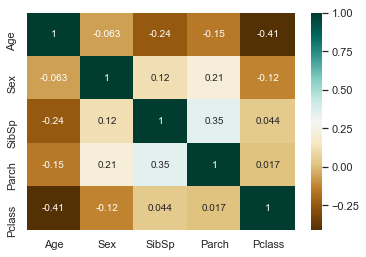

In [65]:
g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(),
                cmap="BrBG", annot=True)

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

상관계수 맵은 Parch를 제외한 factorplot에서의 관측치들을 확인한다. 연령(Age)와 성별(Sex)는 상관이 없지만, Pclass, Parch, SibSp는 연령과 음의 상관관계를 갖는다.

In the plot of Age in function of Parch, Age is growing with the number of parents/children. But the general correlation is negative.

Age와 Parch를 함께 그린 그림에서, Age는 부모/자녀의 숫자와 함께 증가한다. 그러나 일반적인 상관관계는 음의 상관관계를 갖는다.

So I decided to use SibSp, Parch and Pclass in order to impute the missing ages.

그래서 나는 Age의 결측값을 대체하기 위해 SibSp, Parch 그리고 Pclass를 사용하기로 했다.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

전략은 Age를 Pclass, Parch 그리고 SibSp들이 비슷한 row들의 연령의 중앙값을 이용하여 채우는 것이다.

In [66]:
# Filling missing value of Age

## Fill Age with the median age of similar rows 
## according to Pclass, Parch and SibSp

# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset["SibSp"] == dataset.iloc[i]["SibSp"])
                               &
                               (dataset["Parch"] == dataset.iloc[i]["Parch"])
                               &
                               (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()
    
    if not np.isnan(age_pred) :
        dataset["Age"].iloc[i] = age_pred
    else :
        dataset["Age"].iloc[i] = age_med

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\numpy\lib\nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


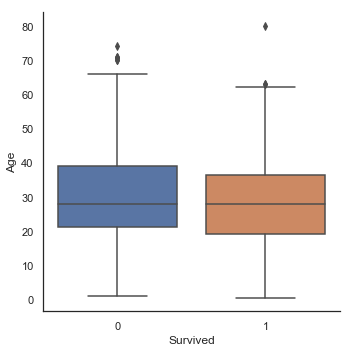

In [67]:
g = sns.factorplot(x="Survived", y="Age", data=train, kind="box")

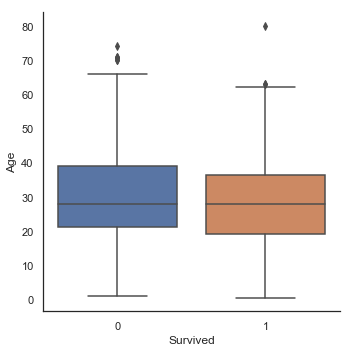

In [68]:
g = sns.catplot(x="Survived", y="Age", data=train, kind="box")

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


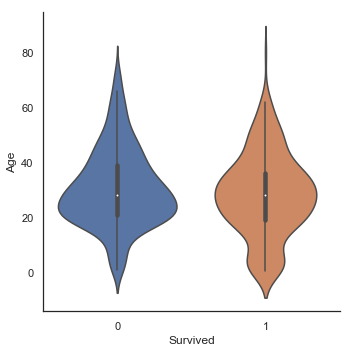

In [69]:
g = sns.factorplot(x="Survived", y="Age", data=train, kind="violin")

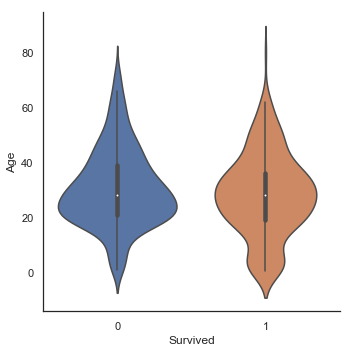

In [70]:
g = sns.catplot(x="Survived", y="Age", data=train, kind="violin")

No difference between median value of age in survived and not survived subpopulation.

생존한 사람들과 그렇지 못한 사람들의 부분모집단의 연령의 중앙값들의 사이에 차이가 없다.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

그러나 생존 승객들의 violin plot에서, 우리는 매우 어린 승객들이 높은 생존율을 가졌다는 것을 알 수 있다.

# 5. Feature Engineering

## 5.1 Name/Title

In [71]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passenger's title.

이름 특성에는 승객의 호칭에 대한 정보가 포함되어 있다.

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

특별한 호칭을 가진 승객들은 탈출 시 더 우선시되기 떄문에, 이것은 그것들을 모델에 넣는 것은 흥미롭다.

In [72]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [73]:
dataset["Title"].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
the Countess      1
Mme               1
Dona              1
Capt              1
Lady              1
Don               1
Jonkheer          1
Sir               1
Name: Title, dtype: int64

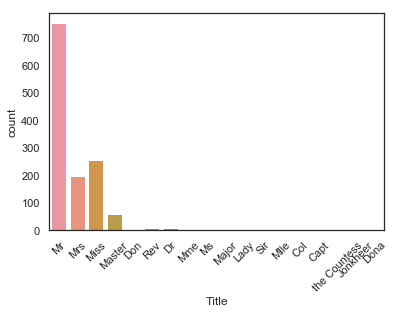

In [74]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

데이터셋에는 17개의 호칭이 있고, 그들 중 대부분은 드물게 나타나고 우리는 그들을 4개의 범주로 묶을 수 있다.

In [75]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(["Lady",
                                             "the Countess",
                                             "Countess",
                                             "Capt",
                                             "Col",
                                             "Don",
                                             "Dr",
                                             "Major",
                                             "Rev",
                                             "Sir",
                                             "Jonkheer",
                                             "Dona"], "Rare")
dataset["Title"] = dataset["Title"].map({"Master": 0,
                                         "Miss": 1,
                                         "Ms": 1,
                                         "Mme": 1,
                                         "Mlle": 1,
                                         "Mrs": 1,
                                         "Mr": 2,
                                         "Rare": 3})
dataset["Title"] = dataset["Title"].astype(int)

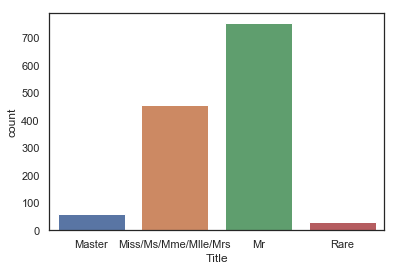

In [76]:
g = sns.countplot(x="Title", data=dataset)
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


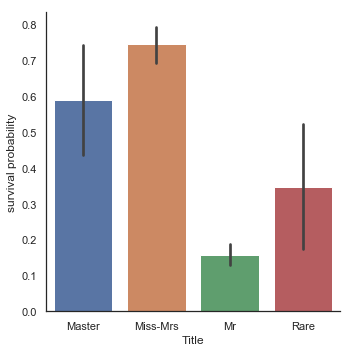

In [77]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("survival probability")

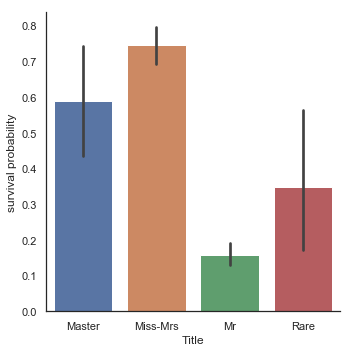

In [78]:
g = sns.catplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("survival probability")

"Women and children first".

It is interesting to note that passengers with rare title have more chance to survive.

드문(rare) 호칭을 가진 승객들이 더 많은 생존 기회를 가졌다는 점은 흥미롭다.

In [79]:
# Drop Name variable
dataset.drop(labels=["Name"], axis=1, inplace=True)

## 5.2 Family size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, I choosed to create a "Fize" (family size) feature which is the sum of SibSp, Parch and 1 (including the passenger).

우리는 가족이 많으면 탈출 과정에서 그들의 여동생, 남동생, 부모님들을 돌봐야 하기 때문에 탈출에 어려움을 겪을 수 있을 것이라고 상상할 수 있다. 그래서 나는 SibSp, Parch 그리고 1(승객 자신 포함)을 합한 숫자인 "Fsize" 라는 새로운 특성을 생성하기로 선택했다.

In [80]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


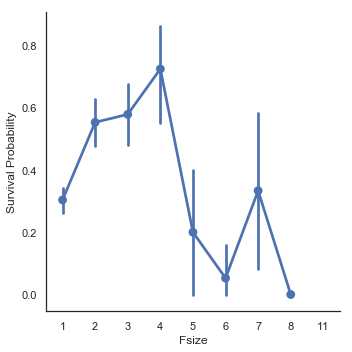

In [81]:
g = sns.factorplot(x="Fsize", y="Survived", data=dataset)
g = g.set_ylabels("Survival Probability")

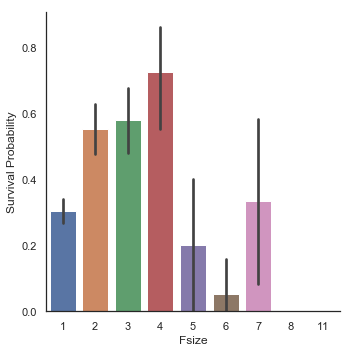

In [82]:
g = sns.catplot(x="Fsize", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

The family size seems to play an important role, survival probability is worst for large families.

가족 크기는 중요한 역할을 하는 것으로 보인다. 생존 확률이 큰 가족들에게서 가장 안좋다.

Additionally, I decided to created 4 categories of family size.

추가적으로, 나는 가족 크기를 4개의 범주로 만들기로 했다.

In [83]:
# Create new feature of family size
dataset["Single"] = dataset["Fsize"].map(lambda s: 1 if s == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s >= 5 else 0)

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


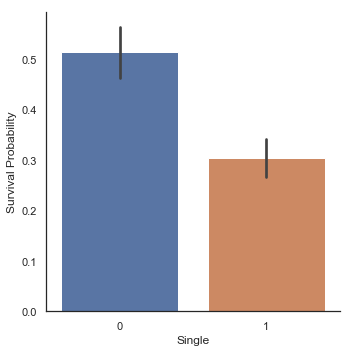

In [84]:
# Single vs Survived
g = sns.factorplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

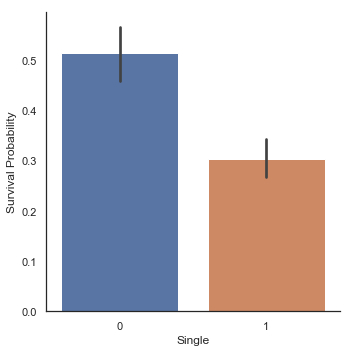

In [85]:
g = sns.catplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


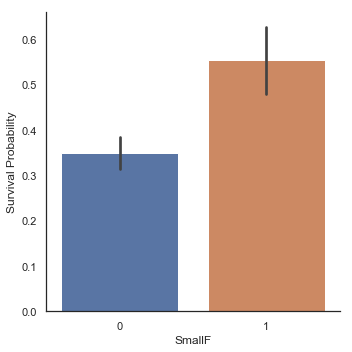

In [86]:
# SmallF vs Survived
g = sns.factorplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

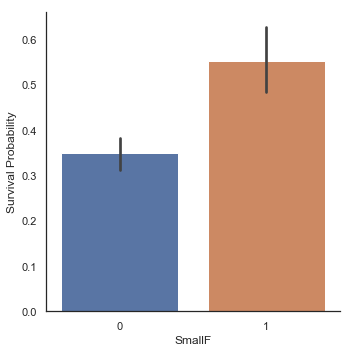

In [87]:
g = sns.catplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


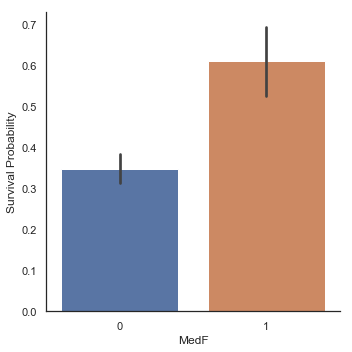

In [88]:
# MedF vs Survived
g = sns.factorplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

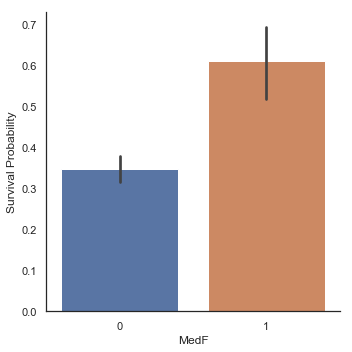

In [89]:
g = sns.catplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


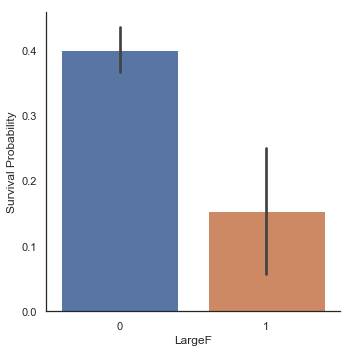

In [90]:
# LargeF vs Survived
g = sns.factorplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

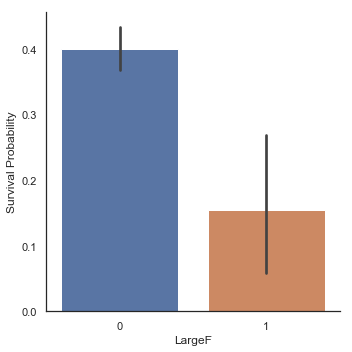

In [91]:
g = sns.catplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

가족 크기 범주들의 Factorplot들은 혼자인 승객과 많은 가족을 가진 승객들보다 작은 가족과 중간 정도의 가족들이 생존 기회가 더 많다는 것을 보여준다.

In [92]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [93]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


At this stage, we have 22 features.

지금 단계에선, 우리는 22개의 특성을 가지고 있다.

## 5.3 Cabin

In [94]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [95]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [96]:
dataset["Cabin"].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.

Cabin 특성 열은 292개의 값과 1007개의 결측값을 포함한다.

I supposed that passengers without a cabin have a missing value displayed instead of the cabin number.

나는 cabin이 없는 승객들은 cabin 번호 대신 결측값으로 표출됐다고 추측했다.

In [97]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [98]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset["Cabin"]])

The first letter of the cabin indicates the Desk, I choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

Cabin의 첫글자는 갑판(Desk)을 가리킨다. 나는 이거시 타이타닉에서 승객의 있을만한 위치를 가리키기 때문에 이 정보만을 유지하기로 선택했다.

In [99]:
dataset["Cabin"].value_counts()

X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

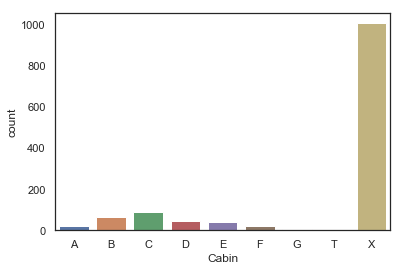

In [100]:
g = sns.countplot(dataset["Cabin"], 
                  order=["A","B","C","D","E","F","G","T","X"])

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


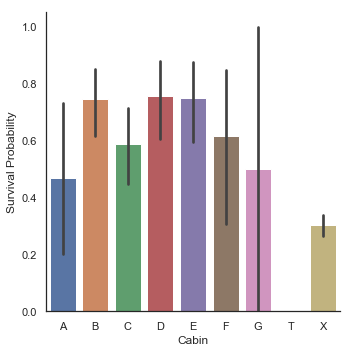

In [101]:
g = sns.factorplot(y="Survived", x="Cabin", data=dataset, kind="bar",
                   order=["A","B","C","D","E","F","G","T","X"])
g = g.set_ylabels("Survival Probability")

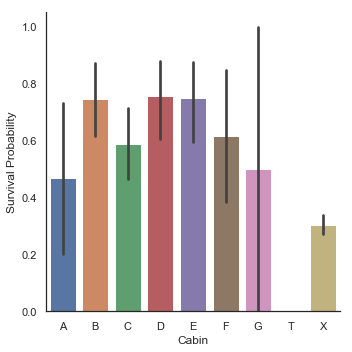

In [102]:
g = sns.catplot(y="Survived", x="Cabin", data=dataset, kind="bar",
                order=["A","B","C","D","E","F","G","T","X"])
g = g.set_ylabels("Survival Probability")

Because of the low number of passenger that have a cabin, survival probabilites have an important standard-deviation and can't distinguish between survival probability of passengers in the different desks.

승객의 적은 숫자만이 Cabin 을 가지고 있기 때문에, 생존 확률은 중요한 표준편차를 갖게 되고 다른 갑판에 있는 승객들의 생존 가능성과 구별할 수 없다.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

그러나 우리는 cabin을 가지고 있는 승객들이 일반적으로 cabin이 없는 승객들보다 더 많은 생존 기회를 가지고 있다는 것을 볼 수 있다.

It is particularly true for cabin B, C, D, E and F.

이는 특히 cabin이 B, C, D, E, F 인 것들에 대해 사실이다.

In [103]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin")

In [104]:
dataset.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,1.981001,0,1,3,0,1,0.0,A/5 21171,2,...,1,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,1,1,1.0,PC 17599,2,...,0,0,0,1,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,...,1,0,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,1,1,1.0,113803,2,...,1,0,0,1,0,0,0,0,0,0
4,35.0,2.085672,0,5,3,0,0,0.0,373450,1,...,1,0,0,0,0,0,0,0,0,1


## 5.4 Ticket

In [105]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

이것은 같은 접두사를 공유하는 Ticket은 Cabin과 함께 예약됐을 것이라는 것을 의미할 수 있다. 따라서 이는 배의 객실의 실제 위치와 이어질 수 있다.

Tickets with same prefixes may have a smiliar class and survival.

같은 접두사를 가진 티켓들은 비스한 등급과 생존여부를 가질 것이다.

So I decided to replace the Ticket feature column by the ticket prefix which may be more informative.

그래서 나는 티켓 특성 열을 더 많은 정보를 제공하는 티켓의 접두사로 대체하기로 결정했다.

In [106]:
## Treat Ticket by extracting the tickt prefix.
## When there is no prefix it returns X.
Ticket = []

for i in list(dataset.Ticket) :
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) # Take prefix
    else :
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [107]:
dataset["Ticket"].value_counts()

X          954
PC          92
CA          61
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
SOC          8
C            8
STONO2       7
SOPP         7
SCParis      5
SCAH         5
LINE         4
WEP          4
PP           4
SOTONO2      3
FC           3
SCA4         2
SWPP         2
PPP          2
SC           2
AQ3          1
SOP          1
CASOTON      1
SP           1
Fa           1
LP           1
A            1
AS           1
STONOQ       1
SCA3         1
AQ4          1
SCOW         1
Name: Ticket, dtype: int64

In [108]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [109]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Pclass"], prefix="Pc")

In [110]:
# Drop useless variables
dataset.drop(labels=["PassengerId"], axis=1, inplace=True)

In [111]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


<br>

# 6. MODELING

In [112]:
## Separate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [113]:
## Spearate train features and label
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"], axis=1)

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<br>

## 6.1 Simple modeling

### 6.1.1 Cross validate models

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified Kfold cross validation procedure.

나는 계층화된 Kfold 교차 검증 절차(stratified Kfold cross validation procedure)를 통해 10개의 인기 있는 분류기를 비교했고 각각 분류기의 평균 정확도를 평가했다.

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perception (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [114]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

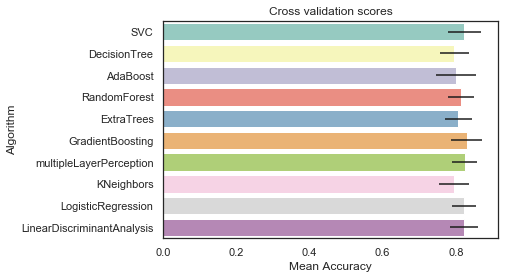

In [115]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,
                                      learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []

for classifier in classifiers :
    cv_results.append(cross_val_score(classifier,
                                      X_train,
                                      y=Y_train,
                                      scoring="accuracy",
                                      cv=kfold,
                                      n_jobs=4)) 
    
cv_means = []
cv_std = []

for cv_result in cv_results :
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means,
                       "CrossValerrors": cv_std,
                       "Algorithm": ["SVC",
                                     "DecisionTree",
                                     "AdaBoost",
                                     "RandomForest",
                                     "ExtraTrees",
                                     "GradientBoosting",
                                     "multipleLayerPerception",
                                     "KNeighbors",
                                     "LogisticRegression",
                                     "LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res,
                palette="Set3", orient="h", **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

I decided to choose the SVC, AdaBoost, RandomForest, ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

나는 앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees 그리고 GraientBoosting 분류기를 선택하기로 결정했다.

<br>

### 6.1.2 Hyperparameter tunning for best models

I performed a grid search optimization for AdaBoost, ExtraTrees, RandomForest, GradientBoosting and SVC classifiers.

나는 AdaBoost, ExtraTrees, RandomForest, GradientBoosting 그리고 SVC 분류기에 대한 그리드 서치 최적화를 수행했다.

I set the "`n_jobs`" parameter to 4 since I have 4 cpu. There computation time is clearly reduced.

나는 4개의 cpu를 가지고 있기 때문에 `n_jobs` 파라미터의 값을 4로 설정했다. 계산 시간이 명확히 감소했다.

But be carefull, this step can take a long time, I took me 15 min in total on 4 cpu.

그러나 주의하라. 이 과정은 긴 시간이 걸릴 수 있다. 나는 4개의 cpu를 이용해 총 15분이 걸렸다.

In [116]:
## META MODELING WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# 1. Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion": ["gini", "entropy"],
                  "base_estimator__splitter": ["best", "random"],
                  "algorithm": ["SAMME", "SAMME.R"],
                  "n_estimators": [1, 2],
                  "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC,
                        param_grid=ada_param_grid,
                        cv=kfold,
                        scoring="accuracy",
                        n_jobs=4,
                        verbose=1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 113 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    7.6s finished


0.8240635641316686

In [117]:
# 2. ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators": [100, 300],
                 "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,
                      param_grid=ex_param_grid,
                      cv=kfold,
                      scoring="accuracy",
                      n_jobs=4,
                      verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   43.2s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   53.4s finished


0.8297389330306469

In [118]:
# 3. RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators": [100, 300],
                 "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,
                     param_grid=rf_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=4,
                     verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   53.2s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.1min finished


0.8354143019296254

In [119]:
# 4. Gradient Boosting Tunning
GBC = GradientBoostingClassifier()

gb_param_grid = {"loss": ["deviance"],
                 "n_estimators": [100, 200, 300],
                 "learning_rate": [0.1, 0.05, 0.01],
                 "max_depth": [4, 8],
                 "min_samples_leaf": [100, 150],
                 "max_features": [0.3, 0.1]}

gsGBC = GridSearchCV(GBC,
                     param_grid=gb_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=4,
                     verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   35.0s finished


0.8331441543700341

In [120]:
# 5. SVC Classifier
SVMC = SVC(probability=True)

svc_param_grid = {"kernel": ["rbf"],
                  "gamma": [0.001, 0.01, 0.1, 1],
                  "C": [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC,
                      param_grid=svc_param_grid,
                      cv=kfold,
                      scoring="accuracy",
                      n_jobs=4,
                      verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   34.6s finished


0.8331441543700341

<br>

### 6.1.3 Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

학습 곡선(`learning_curve`)은 훈련 세트에 대한 과적합 영향과 정확도에 대한 학습 크기의 영향을 확인하는 좋은 방법이다.

In [121]:
def plot_learning_curve(estimator, title, X, y, 
                        ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)) :
    """
    Generate a simple plot of the test and training learning curve
    """
    
    plt.figure()
    plt.title(title)
    
    if ylim is not None :
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X,
                                                            y,
                                                            cv=cv,
                                                            n_jobs=n_jobs,
                                                            train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    
    plt.plot(train_sizes, train_scores_mean,
             "o-", color="r", label="Training score")
    
    plt.plot(train_sizes, test_scores_mean,
             "o-", color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    
    return plt

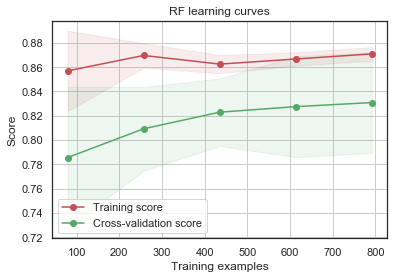

In [122]:
# RandomForestClassifier
g = plot_learning_curve(gsRFC.best_estimator_,
                        "RF learning curves",
                        X_train,
                        Y_train,
                        cv=kfold)

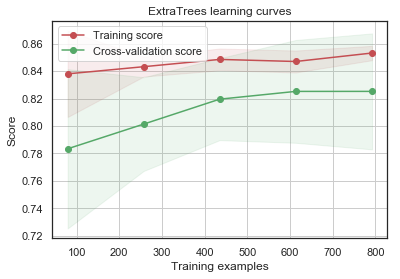

In [123]:
# ExtraTreesClassifier
g = plot_learning_curve(gsExtC.best_estimator_,
                        "ExtraTrees learning curves",
                        X_train,
                        Y_train,
                        cv=kfold)

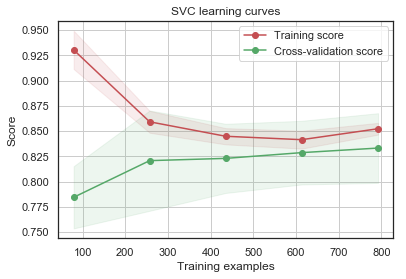

In [124]:
# SupportVectorMachineClassifier
g = plot_learning_curve(gsSVMC.best_estimator_,
                        "SVC learning curves",
                        X_train,
                        Y_train,
                        cv=kfold)

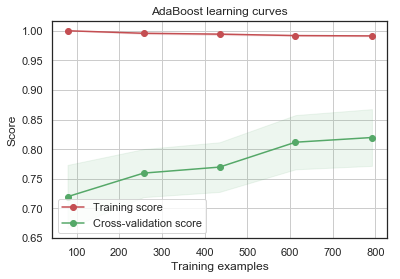

In [125]:
# AdaBoost
g = plot_learning_curve(gsadaDTC.best_estimator_,
                        "AdaBoost learning curves",
                        X_train,
                        Y_train,
                        cv=kfold)

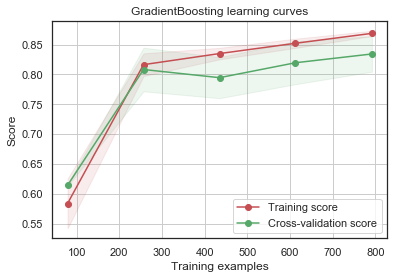

In [126]:
# GradientBoostingClassifier
g = plot_learning_curve(gsGBC.best_estimator_,
                        "GradientBoosting learning curves",
                        X_train,
                        Y_train,
                        cv=kfold)

GradientBoosting and AdaBoost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

GradientBoosting과 AdaBoost 분류기는 훈련 세트에 대해 과적합하는 경향이 있다. GradientBoosting과 Adaboost의 교차 검증 곡선의 성장에 따르면 학습 데이터가 많을 수록 더 좋은 성능을 낼 수 있다.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

SVC와 ExtraTrees 분류기들은 훈련 곡선과 교차 검증 곡선이 비슷하기 때문에 예측이 잘 일반화됐다는 것으로 볼 수 있다.

<br>

### 6.1.4 Feature importance of tree based classifiers

In order to see the most informative features for the prediction of passengers survival, I displayed the feature importance for the 4 tree based classifiers.

승객 생존 예측을 위한 가장 많은 정보를 제공하는 특성들을 보기 위해, 나는 4개의 트리에 기반한 분류기들의 특성 중요도를 표출했다.

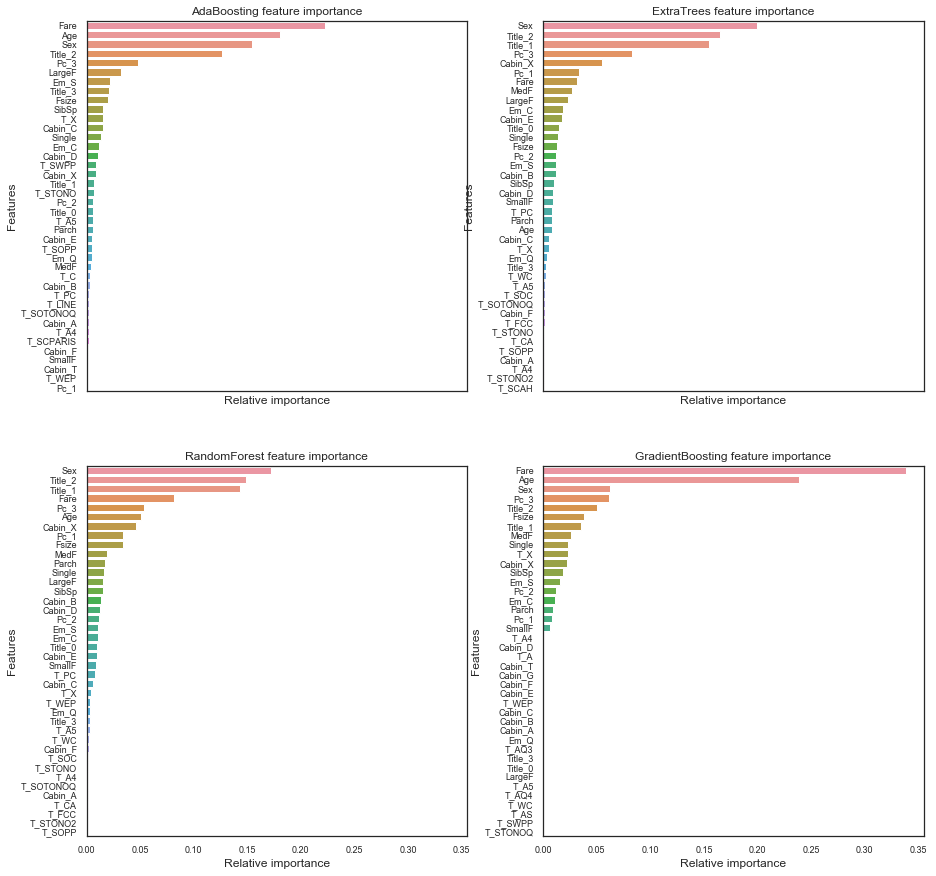

In [127]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),
                     ("ExtraTrees", ExtC_best),
                     ("RandomForest", RFC_best),
                     ("GradientBoosting", GBC_best)]

nclassifier = 0

for row in range(nrows) :
    for col in range(ncols) :
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        
        g = sns.barplot(y=X_train.columns[indices][:40],
                        x=classifier.feature_importances_[indices][:40],
                        orient="h",
                        ax=axes[row][col])
        
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

I plot the feature importance for the 4 tree based classifiers (Adaboost, ExtraTrees, RandomForest and GradientBoosting).

나는 4개의 트리 기반 분류기(AdaBoost, ExtraTrees, RandomForest 그리고 GradientBoosting)에 대한 특성 중요도를 그래프로 그렸다. 

We note that four classifiers have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification, for example, 'Fare', 'Title_2', 'Age' and 'Sex'.

우리는 4개의 분류기가 상대적인 중요도에 따라 상위 특성들이 다르다는 것에 주목해야 한다. 이것은 그들의 예측은 같은 특성에 기반하지 않는다는 것을 의미한다. 그럼에도 불구하고, 그들은 분류에 대해 요금(Fare), 호칭_2(Title_2), 연령(Age) 그리고 성별(Sex)와 같은 어떠한 공통으로 중요한 특성을 공유한다. 

Title_2 which indicates the Mrs/Mlle/Mme/Miss/Ms category is highly correlated with Sex.

Mrs/Mlle/Mme/Miss/Ms 범주를 가리키는 호칭_2(Title_2)는 성별(Sex)와 매우 연관된다.

We can say that:  
- Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.
- Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3(Mr) refer to the gender.
- Age and Title_1 (Master) refer to the age of passengers.
- Fsize, LargeF, MedF, Single refer to the size of the passenger family.

우리는 다음과 같이 말할 수 있다.:  
- 1등급(Pc_1), 2등급(Pc_2), 3등급(Pc_3) 그리고 요금(Fare)는 승객의 사회적 지위를 나타낸다.
- 성별(Sex)과 호칭_2(Title_2) 그리고 호칭_3은 성별을 나타낸다.
- 연령(Age)과 호칭_1은 승객의 나이를 나타낸다.
- Fsize, LargeF, MedF, Single은 승객의 가족 크기를 나타낸다.

**According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the family size and the social standing of the passengers more than the location in the boat.**

4개 분류기들의 특성 중요도에 따르면, 생존 예측은 배의 승선 위치보다 연령, 성별, 가족크기 그리고 승객의 사회적 위치와 더 연관이 있어 보인다.

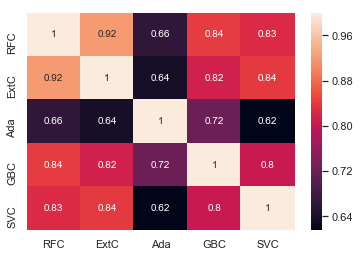

In [128]:
test_Survived_RFC = pd.Series(RFC_best.predict(test),
                              name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test),
                               name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test),
                               name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test),
                               name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test),
                              name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,
                              test_Survived_ExtC,
                              test_Survived_AdaC,
                              test_Survived_GBC,
                              test_Survived_SVMC],
                             axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

The prediction seems to be quite similar for the 5 classifiers except when Adaboost is compared to the others classifiers.

예측은 다른 분류기들과 비교되는 Adaboost를 제외하고 5개의 분류기들에 대해 꽤 비슷해 보인다.

The 5 classifiers give more or less the same prediction but there is some differneces. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

5개의 분류기들은 거의 같은 예측을 하지만 약간의 차이가 있다. 5개 분류기들의 예측의 차이는 앙상블 voting에 고려되기 충분하다.

<br>

## 6.2 Ensembling modeling

### 6.2.1 Combining models

I choosed a voting classifier to combine the predictions coming from the 5 classifiers.

나는 5개의 분류기들로 부터 예측을 결합하기 위해 voting 분류를 선택했다.

I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

나는 각각의 투표 확률을 고려하기 위해 투표 파라미터에 `soft`를 전달하는 것을 선호했다.

In [129]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
                                       ('extc', ExtC_best),
                                       ('svc', SVMC_best),
                                       ('adac', ada_best),
                                       ('gbc', GBC_best)],
                           voting='soft',
                           n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

<br>

## 6.3 Prediction

### 6.3.1 Predict and Submit results

In [130]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest, test_Survived], axis=1)

results.to_csv("ensemble_python_voting.csv", index=False)

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


If you found this notebook helpful or you just liked it, some upvotes would be very much appreciated - That will keep me motivated :)